In [110]:
import torch
import torchvision.transforms as transforms
import torchvision
import os
import glob
import imageio
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
plt.rcParams["figure.figsize"] = (10, 50)

In [2]:
transformers = transforms.Compose([transforms.ToTensor(),
                                  transforms.Resize((112, 112))])
dataset = torchvision.datasets.ImageFolder("/home/fred/datasets/caltech101/101_ObjectCategories/",
                                           transform=transformers)
len(dataset)

8733

In [ ]:
dataset.imgs[9][0]

In [ ]:
img = imageio.imread(dataset.imgs[9][0])
img = transformers(img)
img.shape

In [ ]:
'''
Remove black and white images in caltech101
'''
# folders = glob.glob("/home/fred/datasets/caltech101/101_ObjectCategories/*")
# for folder in folders:
#     img_paths = glob.glob(folder+'/*.jpg')
#     for im_path in img_paths:
#         img = imageio.imread(im_path)
#         if len(img.shape) != 3:
#             os.remove(im_path)

In [ ]:
loader = torch.utils.data.DataLoader(dataset, batch_size=128)

In [ ]:
imgs, labels = next(iter(loader))
imgs.shape

In [ ]:
plt.imshow(imgs[9].permute(1,2,0))


In [124]:
model = torchvision.models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])

In [125]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
features = []
model = model.cuda(0)
for imgs, labels in tqdm(loader):
    imgs = imgs.cuda(0)
    feat = model(imgs)
    features.append(feat.detach().cpu())
    del imgs

features = torch.cat(features).squeeze()

In [ ]:
# path = "/home/fred/datasets/caltech101/feature_tensor.pt"
# with open(path, 'wb') as f:
#     torch.save(features, f)

In [ ]:
path = "/home/fred/datasets/caltech101/feature_tensor.pt"
with open(path, 'rb') as f:
    features = torch.load(f)
features.shape

In [ ]:
img_paths = []
folders = glob.glob("/home/fred/datasets/caltech101/101_ObjectCategories/*")
for folder in folders:
    for path in glob.glob(folder+"/*"):
        img_paths.append(path)

img_paths

In [136]:
class LSH:

    def __init__(self, hash_dim, batch=128):
        self.hash_dim = hash_dim
        self.batch = batch
        self.hash_dict = defaultdict(list)
        
        self.device = torch.device("cuda:0") \
            if torch.cuda.is_available() else torch.device("cpu")
        self.transformers = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize((112, 112))])
        
        model = torchvision.models.resnet50(pretrained=True)
        self.feature_extractor = torch.nn.Sequential(*list(model.children())[:-1]).to(self.device)
        self.feat_dim = 2048
        
        self.hyperplanes = torch.randn((self.feat_dim, self.hash_dim), device=self.device)
    
    def _imgToFeatures(self, img_tensors):
        return self.feature_extractor(img_tensors).squeeze_()

    def _toTuple(self, tensor):
        return tuple(tensor.tolist())

    def _getHashes(self, features):
        
        if len(features.shape) == 1:
            features.unsqueeze_(0)

        hashes = features @ self.hyperplanes  # (batch, hash dim)
        
        hashes[hashes < 0] = 0
        hashes[hashes > 0] = 1
        return hashes.to(torch.int8).cpu()
    
    def _getSmallestDistanceCandidate(self, feat, bucket, num_out, dist_fn=None):
        if dist_fn is None:
            dist_fn = LSH.euclidean_dist
        
        distance = [(path, dist_fn(feat, other_feat.to(self.device))) for path, other_feat in bucket]
        distance.sort(key= lambda x: x[1])
        return distance[:num_out]
    
    def _plotCandidate(self, query_img, candidates):
        
        fig, axes = plt.subplots(nrows=1, ncols=len(candidates) + 1)
        query_img = query_img.squeeze_().permute(1,2,0).cpu()
        axes[0].imshow(query_img)
        axes[0].set_title("Query Image")
        axes[0].set_axis_off()
        for i, (path, dist) in enumerate(candidates):
            img = imageio.imread(path)
            axes[i+1].imshow(img)
            axes[i+1].set_title(f"{dist:.2f}")
            axes[i+1].set_axis_off()
        plt.show()
        
    
        
    @torch.no_grad()
    def build(self, root):
        
        dataset = torchvision.datasets.ImageFolder(root, transform=self.transformers)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch)
        
        all_hashes, all_features = [], []
        for img_batch, _ in tqdm(loader, desc="Hashing"):
            features = self._imgToFeatures(img_batch.to(self.device))
            hashes = self._getHashes(features)
            all_hashes.append(hashes)
            all_features.append(features.cpu())
            
        all_hashes = torch.cat(all_hashes, dim=0)
        all_features = torch.cat(all_features, dim=0)
        
        
        B = all_hashes.shape[0]
        for i in trange(B, desc="Buidling table"):
            tupleHash = self._toTuple(all_hashes[i, :])
            self.hash_dict[tupleHash].append((dataset.imgs[i][0], all_features[i,:]))

        return self.hash_dict

    def query(self, q_paths, num_candidate=5, dist_fn=None):
        
        for q_path in q_paths:
            img = imageio.imread(q_path)
            img = self.transformers(img).unsqueeze_(0).to(self.device)
            
            feat = self._imgToFeatures(img)
            img_hash = self._getHashes(feat).squeeze()
            
            assert len(img_hash.shape) == 1, f"hash has wrong shape {img_hash.shape}"
            
            bucket = self.hash_dict[self._toTuple(img_hash)]
            smallestCandidate = self._getSmallestDistanceCandidate(feat, bucket, num_candidate, dist_fn)
            self._plotCandidate(img, smallestCandidate)
            
    
    @staticmethod
    def euclidean_dist(f1, f2):
        diff = (f1 - f2).squeeze_()
        return math.sqrt(torch.dot(diff, diff))
    

In [137]:
root = "/home/fred/datasets/caltech101/101_ObjectCategories/"
lsh = LSH(hash_dim=16)

hash_dict = lsh.build(root)

Hashing:   0%|          | 0/69 [00:00<?, ?it/s]

Buidling table:   0%|          | 0/8733 [00:00<?, ?it/s]

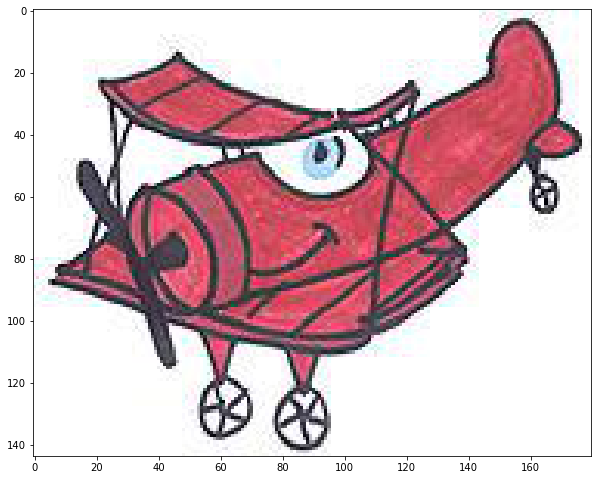

In [138]:
plt.imshow(imageio.imread(dataset.imgs[88][0]))

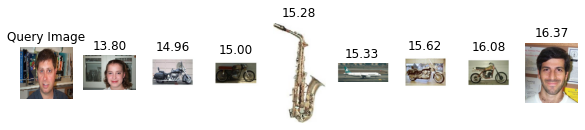

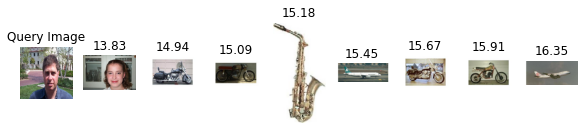

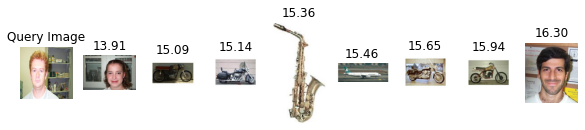

In [142]:
lsh.query([dataset.imgs[456][0], dataset.imgs[457][0], dataset.imgs[458][0]], 8)